## Capstone Project Stage 2: Visual Predictive Model Development

The stage 2 of the Capstone Project, involves,  visual predictive model development for image classification task, starting from JPEG image files on disk, using the Kaggle Sports Dataset (https://www.kaggle.com/datasets/gpiosenka/sports-classification) for binary (two-class) classification

We use the Keras library and  image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

# Setup

#Change the run time to GPU mode
1. Click on Runtime from the menu
2. Change runtime type
3. Pick the hardware accelerator GPU

In [1]:
%cd /content/drive/MyDrive/2023_S2_Teaching


/content/drive/MyDrive/2023_S2_Teaching


In [2]:
#install opencv for python

#!pip install opencv-contrib-python


In [3]:
#%mkdir training_set

In [4]:

#%cp -av '/content/drive/MyDrive/2023_S2_Teaching/train/formula 1 racing/' '/content/drive/MyDrive/2023_S2_Teaching/training_set/'

In [5]:

#%cp -av '/content/drive/MyDrive/2023_S2_Teaching/train/nascar racing' '/content/drive/MyDrive/2023_S2_Teaching/training_set/'

In [6]:
#%mkdir validation_set

In [7]:

#%cp -av '/content/drive/MyDrive/2023_S2_Teaching/valid/formula 1 racing/' '/content/drive/MyDrive/2023_S2_Teaching/validation_set/'

In [8]:

#%cp -av '/content/drive/MyDrive/2023_S2_Teaching/valid/nascar racing/' '/content/drive/MyDrive/2023_S2_Teaching/validation_set/'

In [9]:
#%mkdir test_set

In [10]:

#%cp -av '/content/drive/MyDrive/2023_S2_Teaching/test/formula 1 racing/' '/content/drive/MyDrive/2023_S2_Teaching/test_set/'

In [11]:

#%cp -av '/content/drive/MyDrive/2023_S2_Teaching/valid/nascar racing/' '/content/drive/MyDrive/2023_S2_Teaching/test_set/'

# Generate Dataset

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
!ls '/content/drive/MyDrive/training_set'

'formula 1 racing'  'nascar racing'


In [14]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/training_set",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 379 files belonging to 2 classes.
Using 304 files for training.
Using 75 files for validation.


## Visualise Data
Here are the first 9 images in the training dataset. As you can see, images corresponding to label 1 is "Nascar racing" and label 0 is "Formula 1 racing".

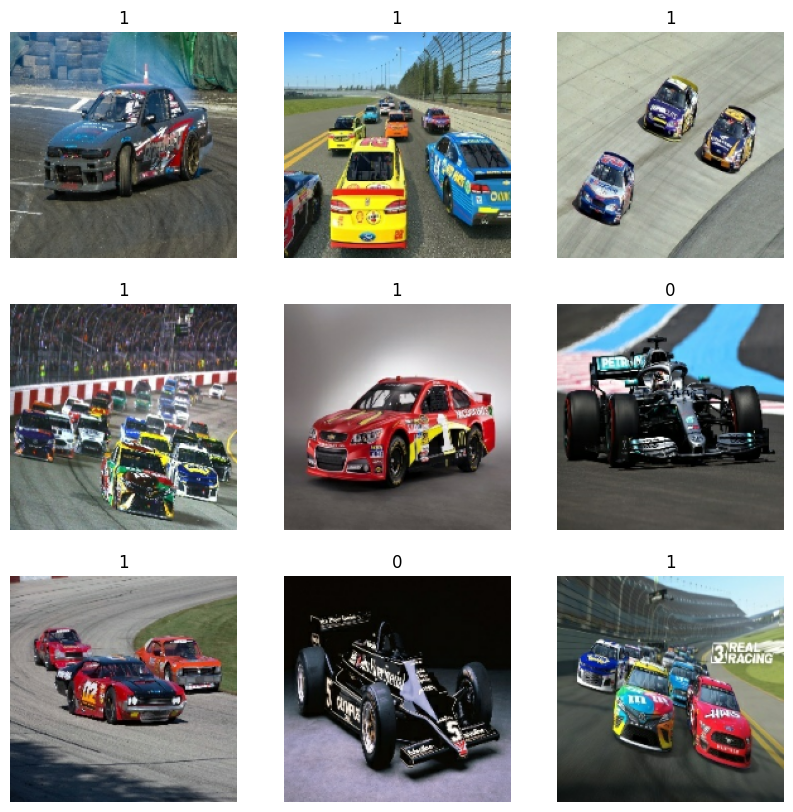

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

## Visualise augmented data

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:

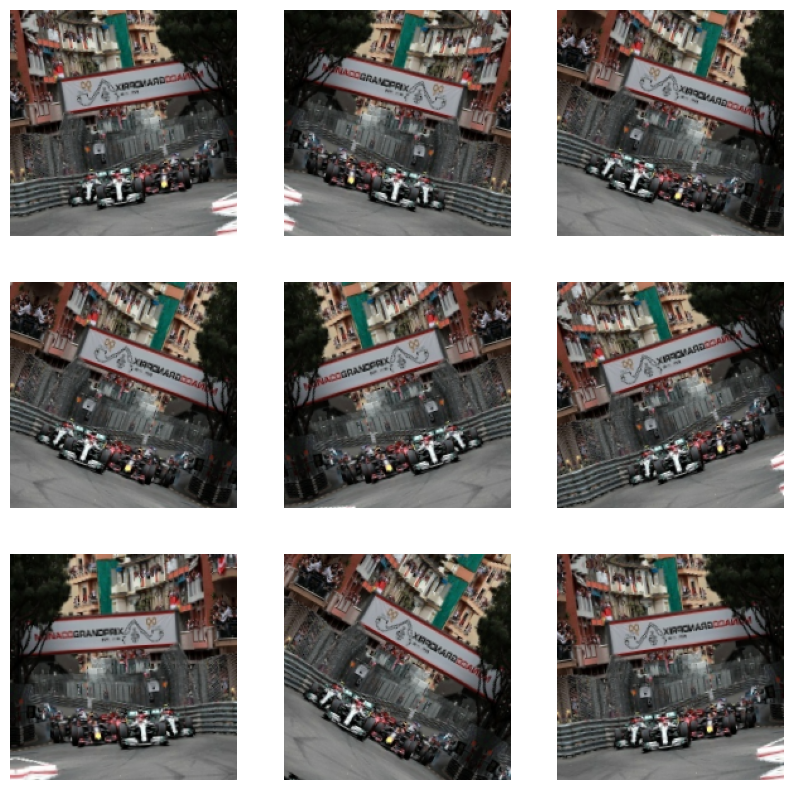

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Preprocessing the augmented data
Configure the dataset for performance
Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [18]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture;
We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

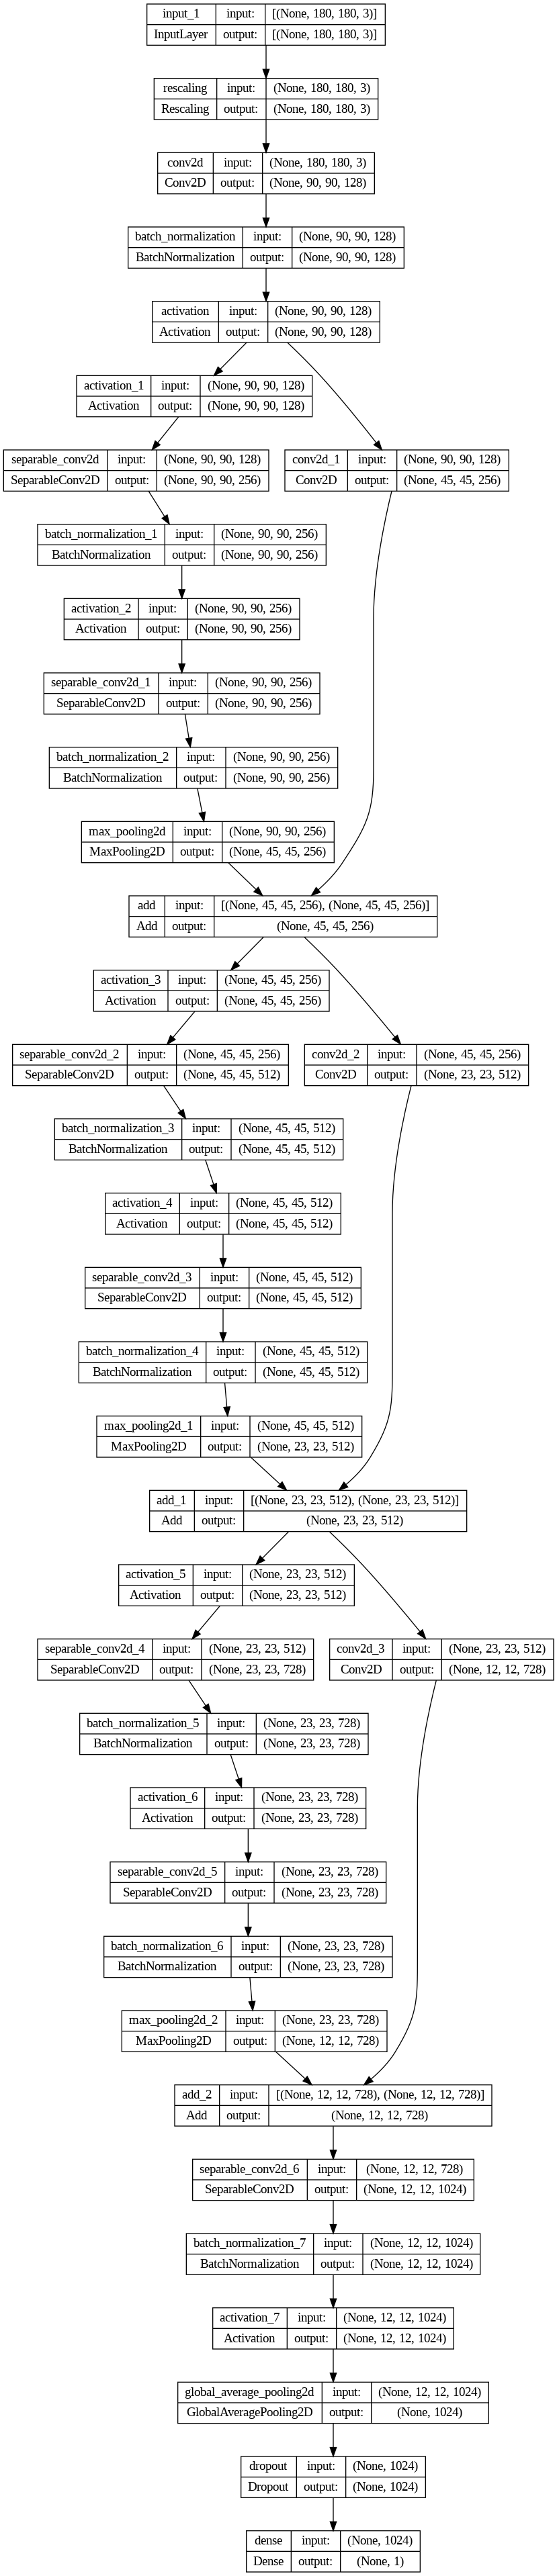

In [19]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [20]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
3/3 [==============================] - 52s 10s/step - loss: 0.7717 - accuracy: 0.5592 - val_loss: 0.6959 - val_accuracy: 0.4267
Epoch 2/25
3/3 [==============================] - 5s 1s/step - loss: 0.7401 - accuracy: 0.5921 - val_loss: 0.6954 - val_accuracy: 0.4267
Epoch 3/25
3/3 [==============================] - 5s 2s/step - loss: 0.6631 - accuracy: 0.6645 - val_loss: 0.6946 - val_accuracy: 0.4267
Epoch 4/25
3/3 [==============================] - 5s 1s/step - loss: 0.5608 - accuracy: 0.7072 - val_loss: 0.6942 - val_accuracy: 0.4267
Epoch 5/25
3/3 [==============================] - 6s 2s/step - loss: 0.5335 - accuracy: 0.7336 - val_loss: 0.6942 - val_accuracy: 0.4267
Epoch 6/25
3/3 [==============================] - 5s 1s/step - loss: 0.5313 - accuracy: 0.7303 - val_loss: 0.6947 - val_accuracy: 0.4267
Epoch 7/25
3/3 [==============================] - 7s 2s/step - loss: 0.4859 - accuracy: 0.7697 - val_loss: 0.6943 - val_accuracy: 0.4267
Epoch 8/25
3/3 [=======================

## Run inference on test data
Note that data augmentation and dropout are inactive at inference time

1/1 [==============================] - 0s 69ms/step
This image is 49.78% Formula 1 racing sport and 50.22% Nascar racing sport.


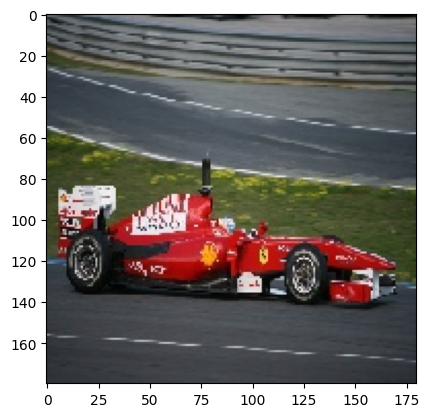

In [24]:

img = keras.utils.load_img(
    "/content/drive/MyDrive/2023_S2_Teaching/test_set/formula 1 racing/1.jpg",
    target_size=image_size)
'''
img = keras.utils.load_img(
    "/content/drive/MyDrive/2023_S2_Teaching/test_set/nascar racing/1.jpg",
    target_size=image_size)
'''
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% Formula 1 racing sport and {100 * score:.2f}% Nascar racing sport.")

# Proceed to next step-Deploying the visual predictive model (Capstone_Project_Stage_3)
